In [1]:
import os
import pickle
import shutil
from time import perf_counter

import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MazeLoader:
    """Loads and parses maze files."""

    def __init__(self):
        """Initialize maze loader."""
        self.dir = "./mazes"

    def parse_shape(self, lines: list[int]) -> tuple[int, int]:
        """Return maze dimensions."""
        parts = lines[0].split()
        if len(parts) != 2:
            raise ValueError(f"Invalid shape line: {lines[0]}")
        return tuple(map(int, parts))

    def parse_wall_count(self, lines: list[int]) -> int:
        """Return number of walls."""
        parts = lines[1].split()
        if len(parts) != 1:
            raise ValueError(f"Invalid wall number line: {lines[1]}")
        return int(parts[0])

    def parse_walls(
        self, lines: list[int]
    ) -> set[tuple[tuple[int, int], tuple[int, int]]]:
        """Return parsed walls."""
        walls = set()
        for line in lines[2:]:
            nums = tuple(map(int, line.split()))
            if len(nums) != 4:
                raise ValueError(f"Invalid wall definition: {line}")
            r1, c1, r2, c2 = nums
            walls.add(((r1, c1), (r2, c2)))
        return walls

    def load(
        self, filename: str
    ) -> tuple[tuple[int, int], int, set[tuple[tuple[int, int], tuple[int, int]]]]:
        """Load maze from file."""
        file = os.path.join(self.dir, f"{filename}.txt")
        with open(file, "r") as f:
            lines = [line.strip() for line in f if line.strip()]
        shape = self.parse_shape(lines)
        wall_count = self.parse_wall_count(lines)
        walls = self.parse_walls(lines)
        return shape, wall_count, walls

    def __call__(self, *args, **kwargs):
        """Call load (wrapper)."""
        return self.load(*args, **kwargs)

In [3]:
class Environment:
    """Maze environment for Q-learning agents."""

    def __init__(
        self,
        shape: tuple[int, int],
        walls: set[tuple[tuple[int, int], tuple[int, int]]],
        start: tuple[tuple[int, int], tuple[int, int]],
        goal: tuple[tuple[int, int], tuple[int, int]],
    ):
        """Init environment with shape, walls, start, and goal."""
        self.shape = shape
        self.walls = {self.normalizeEdge(w) for w in walls}
        self.start = start
        self.goal = goal
        self.current_pos = self.start
        self.validateStartAndGoal()

    def normalizeEdge(
        self, edge: tuple[tuple[int, int], tuple[int, int]]
    ) -> tuple[tuple[int, int], tuple[int, int]]:
        """Normalize a wall edge."""
        return tuple(sorted(edge))

    def isCellValid(self, cell: tuple[tuple[int, int], tuple[int, int]]) -> bool:
        """Check if a cell is valid."""
        (r1, c1), (r2, c2) = cell
        rows, cols = self.shape
        return (0 <= r1 < r2 <= rows) and (0 <= c1 < c2 <= cols)

    def validateStartAndGoal(self) -> None:
        """Validate start and goal cells."""
        if not (self.isCellValid(self.start) and self.isCellValid(self.goal)):
            raise ValueError("Invalid start and/or goal cell.")

    def getNextPos(self, action: str) -> None:
        """Compute next position from action."""
        (r1, c1), (r2, c2) = self.current_pos
        if action == "up":
            return ((r1 - 1, c1), (r2 - 1, c2))
        elif action == "down":
            return ((r1 + 1, c1), (r2 + 1, c2))
        elif action == "left":
            return ((r1, c1 - 1), (r2, c2 - 1))
        elif action == "right":
            return ((r1, c1 + 1), (r2, c2 + 1))
        else:
            raise ValueError(f"Invalid action: {action}")

    def isMoveBlocked(self, next_pos: tuple[tuple[int, int], tuple[int, int]]) -> bool:
        """Check if a move is blocked."""
        (r1, c1) = self.current_pos[0]
        (r2, c2) = next_pos[0]
        if r2 == r1 + 1:
            edge = ((r1 + 1, c1), (r1 + 1, c1 + 1))
        elif r2 == r1 - 1:
            edge = ((r1, c1), (r1, c1 + 1))
        elif c2 == c1 + 1:
            edge = ((r1, c1 + 1), (r1 + 1, c1 + 1))
        elif c2 == c1 - 1:
            edge = ((r1, c1), (r1 + 1, c1))
        else:
            return True
        return self.normalizeEdge(edge) in self.walls

    def setNextPos(self, next_pos: tuple[tuple[int, int], tuple[int, int]]) -> None:
        """Update current position if valid."""
        if not self.isMoveBlocked(next_pos) and self.isCellValid(next_pos):
            self.current_pos = next_pos

    def getReward(self) -> tuple[tuple[tuple[int, int], tuple[int, int]], float, bool]:
        """Return state, reward, and done."""
        done = self.current_pos == self.goal
        reward = 1.0 if done else -0.01
        return self.current_pos, reward, done

    def step(
        self, action: str
    ) -> tuple[tuple[tuple[int, int], tuple[int, int]], float, bool]:
        """Perform action and return resulting state, reward, done."""
        next_pos = self.getNextPos(action)
        self.setNextPos(next_pos)
        return self.getReward()

    def reset(self) -> tuple[tuple[int, int], tuple[int, int]]:
        """Reset environment to start."""
        self.current_pos = self.start
        return self.current_pos

    def generateMazeCoords(self) -> np.ndarray:
        """Generate coordinates for all maze cells."""
        rows = np.arange(self.shape[0] + 1)
        cols = np.arange(self.shape[1])
        r, c = np.meshgrid(rows, cols, indexing="ij")
        start_coords = np.stack([r, c], axis=-1)
        end_coords = np.stack([r, c + 1], axis=-1)
        return np.stack([start_coords, end_coords], axis=-2)

In [4]:
class EpisodeRenderer:
    """Render and animate maze episodes."""

    def __init__(self, env: Environment) -> None:
        """Init renderer with environment."""
        self.env = env
        self.dir = "./renders"

    def setup_axes(self, ax: plt.Axes) -> None:
        """Setup axes for plotting."""
        rows, cols = self.env.shape
        ax.set_xlim(0, cols)
        ax.set_ylim(rows, 0)
        ax.set_aspect("equal")
        ax.set_xticks(range(cols + 1))
        ax.set_yticks(range(rows + 1))
        ax.grid(False)

    def draw_grid(self, ax: plt.Axes) -> None:
        """Draw maze grid lines."""
        rows, cols = self.env.shape
        for row in range(rows):
            ax.plot([0, cols], [row, row], color="lightgray", linewidth=2)
        for col in range(cols + 1):
            ax.plot([col, col], [0, rows], color="lightgray", linewidth=2)

    def draw_walls(self, ax: plt.Axes) -> None:
        """Draw maze walls."""
        for (r1, c1), (r2, c2) in self.env.walls:
            ax.plot([c1, c2], [r1, r2], color="black", linewidth=2, clip_on=False)

    def draw_start(self, ax: plt.Axes) -> None:
        """Draw start cell."""
        (r, c) = self.env.start[0]
        ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor="#006DA0", alpha=0.5))

    def draw_goal(self, ax: plt.Axes) -> None:
        """Draw goal cell."""
        (r, c) = self.env.goal[0]
        ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor="#4CB324", alpha=0.5))

    def plot(self) -> tuple[plt.Figure, plt.Axes]:
        """Draw static maze and return figure and axes."""
        fig, ax = plt.subplots(figsize=(self.env.shape[1], self.env.shape[0]))
        self.setup_axes(ax)
        self.draw_grid(ax)
        self.draw_walls(ax)
        self.draw_start(ax)
        self.draw_goal(ax)
        return fig, ax

    def animate_episode(self, positions: list[tuple[int, int]], ep: int) -> None:
        """Animate agent moving through episode."""
        fig, ax = self.plot()
        (s_r, s_c), _ = self.env.start
        agent = patches.Circle((s_c + 0.5, s_r + 0.5), 0.2, facecolor="black")
        ax.add_patch(agent)

        def update(frame_idx):
            (r1, c1), _ = positions[frame_idx]
            agent.center = (c1 + 0.5, r1 + 0.5)
            return (agent,)

        ani = animation.FuncAnimation(
            fig=fig,
            func=update,
            frames=len(positions),
            interval=200,
        )
        self.save_animation(ani, ep)
        plt.close(fig)

    def save_animation(self, ani: animation.FuncAnimation, filename: str) -> None:
        """Save animation as GIF."""
        file = os.path.join(self.dir, f"{filename}.gif")
        ani.save(file, writer="pillow", fps=5)

    def remove_dir(self) -> None:
        """Remove render directory."""
        if os.path.exists(self.dir):
            shutil.rmtree(self.dir)
        os.makedirs(self.dir, exist_ok=True)

In [5]:
class Agent:
    """Q-learning agent for maze environment."""

    def __init__(
        self,
        env: Environment,
        alpha: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.9,
        checkpoint: int | None = None,
    ):
        """Initialize agent with hyperparameters and optional checkpoint."""
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = ["up", "down", "left", "right"]
        self.Q = self.setQ(checkpoint)
        self.dir = "./checkpoints"
        self.do_train: bool = True

    def setQ(self, Q_file: str) -> np.ndarray | None:
        """Initialize or load Q-table."""
        if Q_file is None:
            rows, cols = self.env.shape
            return np.zeros((rows, cols, len(self.actions)))
        return self.loadQ(Q_file)

    def chooseAction(self, state: tuple[int, int]) -> str:
        """Select action using epsilon-greedy policy."""
        r, c = state
        if self.do_train and np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        return self.actions[np.argmax(self.Q[r, c, :])]

    def updateQ(
        self,
        state: tuple[int, int],
        action: str,
        reward: float,
        next_state: tuple[int, int],
    ) -> None:
        """Update Q-table using Q-learning rule."""
        if self.do_train:
            r, c = state
            a = self.actions.index(action)
            nr, nc = next_state
            max_next = np.max(self.Q[nr, nc, :])
            self.Q[r, c, a] += self.alpha * (
                reward + self.gamma * max_next - self.Q[r, c, a]
            )

    def printQ(self) -> None:
        """Print current Q-table."""
        print(f"{np.array2string(self.Q, precision=2, suppress_small=True)}\n")

    def saveQ(self, ep: int) -> None:
        """Save Q-table to file."""
        os.makedirs(self.dir, exist_ok=True)
        file = os.path.join(self.dir, f"{ep}.pkl")
        with open(file, "wb") as f:
            pickle.dump(self.Q, f)

    def loadQ(self, filename: str) -> np.ndarray:
        """Load Q-table from file."""
        file = os.path.join(self.dir, f"{filename}.pkl")
        with open(file, "rb") as f:
            return pickle.load(f)

    def load_last(self) -> None:
        """Load the last saved Q-table."""
        files = os.listdir(self.dir)
        episodes = sorted([int(f[:-4]) for f in files])
        last_ep = episodes[-1]
        self.Q = self.loadQ(last_ep)

    def remove_dir(self) -> None:
        """Remove checkpoint directory."""
        if os.path.exists(self.dir):
            shutil.rmtree(self.dir)
        os.makedirs(self.dir, exist_ok=True)

In [6]:
class Trainer:
    """Trainer for Q-learning agent in maze environment."""

    def __init__(
        self,
        env: Environment,
        agent: Agent,
        episodes: int,
    ):
        """Initialize trainer with environment, agent, and episode count."""
        self.env = env
        self.agent = agent
        self.renderer = EpisodeRenderer(env)
        self.episodes = episodes

    def remove_dirs(self, ok: bool) -> None:
        """Remove previous training and render directories."""
        if ok:
            self.agent.remove_dir()
            self.renderer.remove_dir()

    def reset_metrics(self) -> None:
        """Reset training metrics for rewards and episode durations."""
        self.rewards_per_episode = []
        self.episode_times = []

    def train(
        self,
        decay_every: int = 50,
        animate_every: int = 500,
        remove_prev_train: bool = True,
        load_from: str | None = None
    ) -> None:
        """Run full training loop with optional animation and epsilon decay."""
        if load_from: 
            self.load_q_table(load_from)
        self.reset_metrics()
        self.remove_dirs(remove_prev_train)
        self.agent.do_train = True
        for ep in range(1, self.episodes + 1):
            positions, total_reward = self.runEpisode()
            self.animate(positions, ep, animate_every)
            self.decayEpsilon(ep, decay_every)
            self.rewards_per_episode.append(total_reward)
        self.endTrain(ep)

    def stepEpisode(
        self, state: tuple[int, int]
    ) -> tuple[tuple[int, int], float, bool]:
        """Take a single environment step and update Q-table."""
        action = self.agent.chooseAction(state)
        next_pos, reward, done = self.env.step(action)
        next_state = next_pos[0]
        self.agent.updateQ(state, action, reward, next_state)
        return next_state, reward, done

    def runEpisode(self) -> tuple[list[tuple[tuple[int, int], tuple[int, int]]], float]:
        """Run one episode, returning positions and total reward."""
        state = self.env.reset()[0]
        done = False
        total_reward = 0
        start_time = perf_counter()
        positions = [self.env.current_pos]
        while not done:
            state, reward, done = self.stepEpisode(state)
            positions.append(self.env.current_pos)
            total_reward += reward
        end_time = perf_counter()
        self.episode_times.append(end_time - start_time)
        return positions, total_reward

    def animate(
        self,
        positions: list[tuple[tuple[int, int], tuple[int, int]]],
        ep: int,
        every: int = 100,
    ) -> None:
        """Animate episode if the interval is reached."""
        if ep % every == 0 or ep == self.episodes:
            self.renderer.animate_episode(positions, ep)

    def decayEpsilon(self, ep: int, every: int = 100) -> None:
        """Decay epsilon at specified intervals."""
        if ep % every == 0:
            self.agent.epsilon *= 0.9

    def showQ(self, ep: int, every: int = 100) -> None:
        """Display Q-table at intervals."""
        if ep % every == 0 or ep == self.episodes:
            print(f"Q-table at episode {ep}:")
            self.agent.printQ()

    def summarizeTraining(self) -> None:
        """Print a summary of training performance."""
        total_episodes = len(self.rewards_per_episode)
        total_reward = np.sum(self.rewards_per_episode)
        mean_reward = np.mean(self.rewards_per_episode)
        best_reward = np.max(self.rewards_per_episode)
        worst_reward = np.min(self.rewards_per_episode)
        mean_time = np.mean(self.episode_times)
        best_time = np.min(self.episode_times)
        worst_time = np.max(self.episode_times)
        print("===== Training Summary =====")
        print(f"Total Episodes: {total_episodes}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Average Reward per Episode: {mean_reward:.2f}")
        print(f"Best Episode Reward: {best_reward:.2f}")
        print(f"Worst Episode Reward: {worst_reward:.2f}")
        print("----------------------------")
        print(f"Average Episode Time: {mean_time:.4f} s")
        print(f"Fastest Episode Time: {best_time:.4f} s")
        print(f"Slowest Episode Time: {worst_time:.4f} s")
        print("============================")

    def plotRewardsPerEpisode(self) -> None:
        """Plot rewards per episode."""
        plt.plot(self.rewards_per_episode)
        plt.title("Rewards per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    def plotEpisodeTimes(self) -> None:
        """Plot execution time per episode."""
        plt.plot(self.episode_times, color="orange")
        plt.title("Execution Time per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Time (seconds)")
        plt.grid(True)
        plt.show()

    def endTrain(self, ep: int) -> None:
        """Finalize training, save Q-table, and show summary plots."""
        self.agent.saveQ(ep)
        self.summarizeTraining()
        self.plotRewardsPerEpisode()
        self.plotEpisodeTimes()

    def load_q_table(self, path: str | None = None):
        """Load the Q-table from a given path or from the last saved checkpoint."""
        if path:
            self.agent.Q = self.agent.loadQ(path)
        else:
            self.agent.load_last()

    def val(self, load_from: str | None  =None) -> None:
        """Run a validation episode using the last checkpoint."""
        self.load_q_table(load_from)
        self.agent.do_train = False
        positions, reward = self.runEpisode()
        print(f"Validation reward: {reward:.2f}")
        print(f"Total steps: {len(positions)}")
        self.renderer.animate_episode(positions, "val")

===== Training Summary =====
Total Episodes: 2240
Total Reward: 1077.54
Average Reward per Episode: 0.48
Best Episode Reward: 0.76
Worst Episode Reward: -33.41
----------------------------
Average Episode Time: 0.0004 s
Fastest Episode Time: 0.0001 s
Slowest Episode Time: 0.0358 s


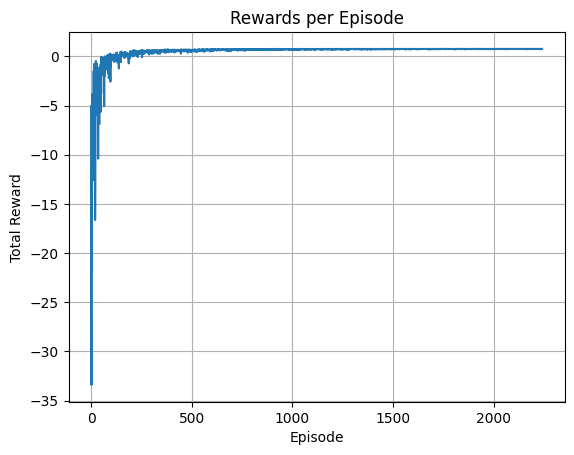

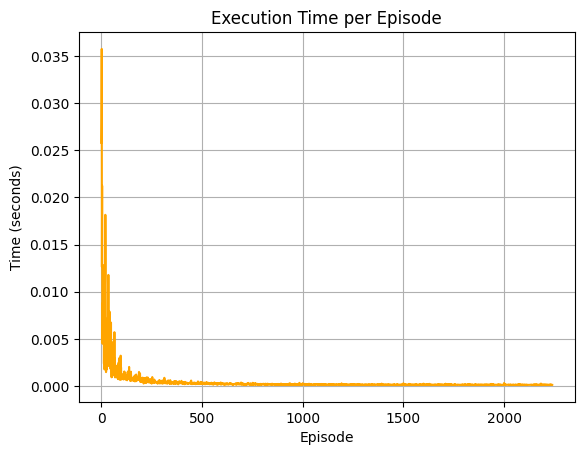

In [7]:
shape, _, walls = MazeLoader()("maze_2")
start = ((6, 0), (7, 1))
goal = ((1, 6), (2, 7))
env = Environment(shape, walls, start, goal)
agent = Agent(env)
episodes = env.shape[0] * env.shape[1] * len(agent.actions) * 10
trainer = Trainer(env, agent, episodes)
trainer.train()

In [8]:
trainer.val("2240")

Validation reward: 0.76
Total steps: 26
